# Business Problem
- In order for the company to plan for the medium to long term, it is necessary to estimate the potential value that existing customers will provide to the company in the future.

# Data Story
- The dataset has information on 100,000 orders made from 2016 to 2018 across multiple marketplaces in Brazil. 
- Its features allow viewing an order from multiple dimensions: from order status, price, payment and freight performance, to customer location, product attributes. 
- The dataset consists of information derived from customers' past shopping behavior.

- **Customer data set:** 117601 observations, 3 variables

- **order_id:** Order number
- **customer_id:** Customer number
- **payment_value:** Total price paid by the customer

- **Order data set:** 99441 observations, 2 variables

- **order_id:** Order number
- **order_purchase_timestamp:** Date of customer purchase

In [1]:
!pip install lifetimes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.2/584.2 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 3.7 MB/s eta 0:00:00


In [2]:
# import Required Libraries

import pandas as pd
import numpy as np
import seaborn as sns
import datetime as dt

import matplotlib.pyplot as plt
import plotly.express as px
import warnings

from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions

warnings.simplefilter(action="ignore")

In [3]:
# Adjusting Row Column Settings
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", lambda x: '%.4f' % x)

In [4]:
# Loading the Data Set
df1 = pd.read_csv('/kaggle/input/dataset2/order.csv')
df2 = pd.read_csv('/kaggle/input/dataset2/customer.csv')

In [5]:
df1.head()

,order_purchase_timestamp,order_id
0,2017-10-02 10:56:33,e481f51cbdc54678b7cc49136f2d6af7
1,2018-07-24 20:41:37,53cdb2fc8bc7dce0b6741e2150273451
2,2018-08-08 08:38:49,47770eb9100c2d0c44946d9cf07ec65d
3,2017-11-18 19:28:06,949d5b44dbf5de918fe9c16f97b45f8a
4,2018-02-13 21:18:39,ad21c59c0840e6cb83a9ceb5573f8159


In [6]:
df2.head()

,order_id,customer_id,payment_value
0,00010242fe8c5a6d1ba2dd792cb16214,48436dade18ac8b2bce089ec2a041202,72.1900
1,00018f77f2f0320c557190d7a144bdd3,dd7ddc04e1b6c2c614352b383efe2d36,259.8300
2,000229ec398224ef6ca0657da4fc703e,5b51032eddd242adc84c38acab88f23d,216.8700
3,00024acbcdf0a6daa1e931b038114c75,9d7a1d34a5052409006425275ba1c2b4,25.7800
4,00042b26cf59d7ce69dfabb4e55b4fd9,df560393f3a51e74553ab94004ba5c87,218.0400


In [7]:
df = pd.merge(df1,df2,on="order_id", how = "inner" )

In [8]:
df.head()

,order_purchase_timestamp,order_id,customer_id,payment_value
0,2017-10-02 10:56:33,e481f51cbdc54678b7cc49136f2d6af7,3504c0cb71d7fa48d967e0e4c94d59d9,18.1200
1,2017-10-02 10:56:33,e481f51cbdc54678b7cc49136f2d6af7,3504c0cb71d7fa48d967e0e4c94d59d9,2.0000
2,2017-10-02 10:56:33,e481f51cbdc54678b7cc49136f2d6af7,3504c0cb71d7fa48d967e0e4c94d59d9,18.5900
3,2018-07-24 20:41:37,53cdb2fc8bc7dce0b6741e2150273451,289cdb325fb7e7f891c38608bf9e0962,141.4600
4,2018-08-08 08:38:49,47770eb9100c2d0c44946d9cf07ec65d,4869f7a5dfa277a7dca6462dcf3b52b2,179.1200


In [9]:
# Preliminary examination of the data set
def check_df(dataframe, head=5):
    print('##################### Shape #####################')
    print(dataframe.shape)
    print('##################### Types #####################')
    print(dataframe.dtypes)
    print('##################### Head #####################')
    print(dataframe.head(head))
    print('##################### Tail #####################')
    print(dataframe.tail(head))
    print('##################### NA #####################')
    print(dataframe.isnull().sum())
    print('##################### Quantiles #####################')
    print(dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

check_df(df)

##################### Shape #####################
(117601, 4)
##################### Types #####################
order_purchase_timestamp     object
order_id                     object
customer_id                  object
payment_value               float64
dtype: object
##################### Head #####################
  order_purchase_timestamp                          order_id  \
0      2017-10-02 10:56:33  e481f51cbdc54678b7cc49136f2d6af7   
1      2017-10-02 10:56:33  e481f51cbdc54678b7cc49136f2d6af7   
2      2017-10-02 10:56:33  e481f51cbdc54678b7cc49136f2d6af7   
3      2018-07-24 20:41:37  53cdb2fc8bc7dce0b6741e2150273451   
4      2018-08-08 08:38:49  47770eb9100c2d0c44946d9cf07ec65d   

                        customer_id  payment_value  
0  3504c0cb71d7fa48d967e0e4c94d59d9        18.1200  
1  3504c0cb71d7fa48d967e0e4c94d59d9         2.0000  
2  3504c0cb71d7fa48d967e0e4c94d59d9        18.5900  
3  289cdb325fb7e7f891c38608bf9e0962       141.4600  
4  4869f7a5dfa277a7dca6462dcf3b

In [10]:
# Examination of numerical and categorical variables

def grab_col_names(dataframe, cat_th=10, car_th=20):
    """
    Returns the names of categorical, numeric and categorical but cardinal variables in the data set.
    Note Categorical variables include categorical variables with numeric appearance.
    Parameters
    ------
         dataframe: dataframe
                Dataframe to get variable names
        cat_th: int, optional
                class threshold for numeric but categorical variables
        car_th: int, optinal
                class threshold for categorical but cardinal variables
    Returns
    ------
        cat_cols: list
                Categorical variable list
        num_cols: list
                Numeric variable list
        cat_but_car: list
                List of cardinal variables with categorical view
    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))
    Notes
    ------
        cat_cols + num_cols + cat_but_car = total number of variables
        num_but_cat is inside cat_cols.
        The sum of the 3 return lists equals the total number of variables: cat_cols + num_cols + cat_but_car = number of variables
    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == 'O']
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != 'O']
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == 'O']
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != 'O']
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f'Observations: {dataframe.shape[0]}')
    print(f'Variables: {dataframe.shape[1]}')
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car, num_but_cat

cat_cols, num_cols, cat_but_car, num_but_cat = grab_col_names(df)

Observations: 117601
Variables: 4
cat_cols: 0
num_cols: 1
cat_but_car: 3
num_but_cat: 0


In [11]:
# changed the type

df["order_purchase_timestamp"] = pd.to_datetime(df["order_purchase_timestamp"])

In [12]:
df["order_purchase_timestamp"].max()

Timestamp('2018-09-03 09:06:57')

In [13]:
# Present Date (date of analysis)

today_date = dt.datetime(2018, 9, 5)

In [14]:
cltv_df = df.groupby('customer_id').agg(
                    {'order_purchase_timestamp': [lambda order_purchase_timestamp: (order_purchase_timestamp.max() - order_purchase_timestamp.min()).days,
                                                  lambda order_purchase_timestamp: (today_date - order_purchase_timestamp.min()).days],
                    'order_id': lambda x: x.nunique(),
                    'payment_value': lambda TotalPrice: TotalPrice.sum()})

In [15]:
cltv_df.head()

order_purchase_timestamp            order_id  \
                                               <lambda_0> <lambda_1> <lambda>   
customer_id                                                                     
0015a82c2db000af6aaaf3ae2ecb0532                       21        343        3   
001cca7ae9ae17fb1caed9dfb1094831                      523        577      200   
001e6ad469a905060d959994f1b41e4f                        0         28        1   
002100f778ceb8431b7a1020ff7ab48f                      210        355       51   
003554e2dce176b5555353e4f3555ac8                        0        263        1   

                                 payment_value  
                                      <lambda>  
customer_id                                     
0015a82c2db000af6aaaf3ae2ecb0532     2748.0600  
001cca7ae9ae17fb1caed9dfb1094831    48349.2200  
001e6ad469a905060d959994f1b41e4f      267.9400  
002100f778ceb8431b7a1020ff7ab48f     2445.6400  
003554e2dce176b5555353e4f3555ac8      139.3800

In [16]:
cltv_df.columns = cltv_df.columns.droplevel(0)

In [17]:
cltv_df.head()

,<lambda_0>,<lambda_1>,<lambda>,<lambda>
customer_id,,,,
0015a82c2db000af6aaaf3ae2ecb0532,21,343,3,2748.0600
001cca7ae9ae17fb1caed9dfb1094831,523,577,200,48349.2200
001e6ad469a905060d959994f1b41e4f,0,28,1,267.9400
002100f778ceb8431b7a1020ff7ab48f,210,355,51,2445.6400
003554e2dce176b5555353e4f3555ac8,0,263,1,139.3800


In [18]:
# Change the columns name

cltv_df.columns = ['recency', 'T', 'frequency', 'monetary']


In [19]:
cltv_df.head()

,recency,T,frequency,monetary
customer_id,,,,
0015a82c2db000af6aaaf3ae2ecb0532,21,343,3,2748.0600
001cca7ae9ae17fb1caed9dfb1094831,523,577,200,48349.2200
001e6ad469a905060d959994f1b41e4f,0,28,1,267.9400
002100f778ceb8431b7a1020ff7ab48f,210,355,51,2445.6400
003554e2dce176b5555353e4f3555ac8,0,263,1,139.3800


We will need to convert the types of these values so that we can do the calculations and apply the model.
- Recency = weekly
- Monetary = Average
- T = weekly

In [20]:
# We calculated the average value for each customer.

cltv_df["monetary"] = cltv_df["monetary"] / cltv_df["frequency"]

In [21]:
cltv_df.head()

,recency,T,frequency,monetary
customer_id,,,,
0015a82c2db000af6aaaf3ae2ecb0532,21,343,3,916.0200
001cca7ae9ae17fb1caed9dfb1094831,523,577,200,241.7461
001e6ad469a905060d959994f1b41e4f,0,28,1,267.9400
002100f778ceb8431b7a1020ff7ab48f,210,355,51,47.9537
003554e2dce176b5555353e4f3555ac8,0,263,1,139.3800


In [22]:
# We chose frequency to be greater than 1.

cltv_df = cltv_df[(cltv_df['frequency'] > 1)]

In [23]:
cltv_df.head()

,recency,T,frequency,monetary
customer_id,,,,
0015a82c2db000af6aaaf3ae2ecb0532,21,343,3,916.0200
001cca7ae9ae17fb1caed9dfb1094831,523,577,200,241.7461
002100f778ceb8431b7a1020ff7ab48f,210,355,51,47.9537
004c9cd9d87a3c30c522c48c4fc07416,461,585,158,176.0149
00720abe85ba0859807595bbf045a33b,188,220,13,239.8769


In [24]:
# We converted the recency value to weekly.

cltv_df["recency"] = cltv_df["recency"] / 7

In [25]:
cltv_df.head()

,recency,T,frequency,monetary
customer_id,,,,
0015a82c2db000af6aaaf3ae2ecb0532,3.0000,343,3,916.0200
001cca7ae9ae17fb1caed9dfb1094831,74.7143,577,200,241.7461
002100f778ceb8431b7a1020ff7ab48f,30.0000,355,51,47.9537
004c9cd9d87a3c30c522c48c4fc07416,65.8571,585,158,176.0149
00720abe85ba0859807595bbf045a33b,26.8571,220,13,239.8769


In [26]:
# We translated the age of the customer on a weekly basis.

cltv_df["T"] = cltv_df["T"] / 7

In [27]:
cltv_df.head()

,recency,T,frequency,monetary
customer_id,,,,
0015a82c2db000af6aaaf3ae2ecb0532,3.0000,49.0000,3,916.0200
001cca7ae9ae17fb1caed9dfb1094831,74.7143,82.4286,200,241.7461
002100f778ceb8431b7a1020ff7ab48f,30.0000,50.7143,51,47.9537
004c9cd9d87a3c30c522c48c4fc07416,65.8571,83.5714,158,176.0149
00720abe85ba0859807595bbf045a33b,26.8571,31.4286,13,239.8769


# Establishment of BG-NBD Model

In [28]:
# Created model object

bgf = BetaGeoFitter(penalizer_coef=0.001)

In [29]:
# Model fitting

bgf.fit(cltv_df['frequency'],
        cltv_df['recency'],
        cltv_df['T'])

<lifetimes.BetaGeoFitter: fitted with 2524 subjects, a: 0.34, alpha: 0.80, b: 4.36, r: 0.88>

# Who are the customers we expect to purchase the most during the week?

In [30]:
cltv_df["expected_purc_4_weeks"] = bgf.predict(4,
                                              cltv_df['frequency'],
                                              cltv_df['recency'],
                                              cltv_df['T'])

In [31]:
cltv_df.head()

,recency,T,frequency,monetary,expected_purc_4_weeks
customer_id,,,,,
0015a82c2db000af6aaaf3ae2ecb0532,3.0000,49.0000,3,916.0200,0.0003
001cca7ae9ae17fb1caed9dfb1094831,74.7143,82.4286,200,241.7461,0.0000
002100f778ceb8431b7a1020ff7ab48f,30.0000,50.7143,51,47.9537,0.0000
004c9cd9d87a3c30c522c48c4fc07416,65.8571,83.5714,158,176.0149,0.0000
00720abe85ba0859807595bbf045a33b,26.8571,31.4286,13,239.8769,1.4455


In [32]:
cltv_df.sort_values(by='expected_purc_4_weeks', ascending=False).head()

,recency,T,frequency,monetary,expected_purc_4_weeks
customer_id,,,,,
fa1c13f2614d7b5c4749cbc52fecda94,85.4286,86.4286,585,353.0141,17.8860
2a84855fd20af891be03bc5924d2b453,34.8571,35.7143,164,126.5840,16.1232
9f505651f4a6abe901a56cdc21508025,46.8571,47.7143,397,92.7736,16.0996
4e922959ae960d389249c378d1c939f5,98.1429,99.1429,420,145.4073,15.8664
16090f2ca825584b5a147ab24aa30c86,81.8571,83.0000,402,79.6411,15.7738


# Evaluation of Forecast Results


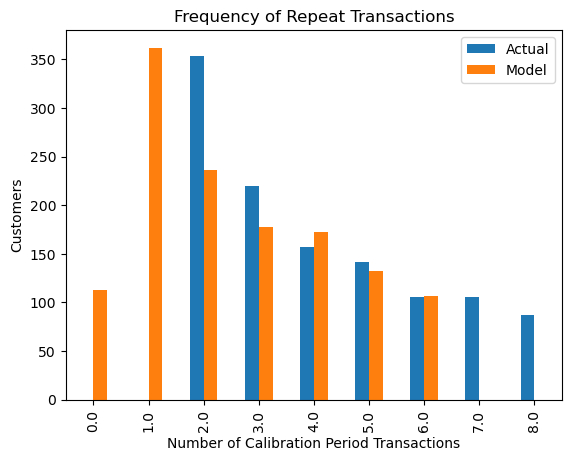

In [33]:
plot_period_transactions(bgf)
plt.show(block=True)

# Establishing the GAMMA-GAMMA Model

In [34]:
# Created model object

ggf = GammaGammaFitter(penalizer_coef=0.01)

In [35]:
# Model fitting

ggf.fit(cltv_df['frequency'], cltv_df['monetary'])

<lifetimes.GammaGammaFitter: fitted with 2524 subjects, p: 3.88, q: 0.41, v: 3.84>

In [36]:
# Expected average profit

cltv_df["expected_average_profit"] = ggf.conditional_expected_average_profit(cltv_df['frequency'],
                                                                             cltv_df['monetary'])

# Calculation of CLTV with BG-NBD and GG model

In [37]:
cltv_df["clv"] = ggf.customer_lifetime_value(bgf,
                                   cltv_df['frequency'],
                                   cltv_df['recency'],
                                   cltv_df['T'],
                                   cltv_df['monetary'],
                                   time=3,  # 3 months
                                   freq="W",  # Frequency information of T
                                   discount_rate=0.01)

In [38]:
cltv_df = cltv_df.reset_index()

In [39]:
cltv_df.head()

,customer_id,recency,T,frequency,monetary,expected_purc_4_weeks,expected_average_profit,clv
0,0015a82c2db000af6aaaf3ae2ecb0532,3.0000,49.0000,3,916.0200,0.0003,966.2073,0.8196
1,001cca7ae9ae17fb1caed9dfb1094831,74.7143,82.4286,200,241.7461,0.0000,241.9490,0.0144
2,002100f778ceb8431b7a1020ff7ab48f,30.0000,50.7143,51,47.9537,0.0000,48.1724,0.0000
3,004c9cd9d87a3c30c522c48c4fc07416,65.8571,83.5714,158,176.0149,0.0000,176.2085,0.0000
4,00720abe85ba0859807595bbf045a33b,26.8571,31.4286,13,239.8769,1.4455,243.0107,1084.6604


# Creation of Segments According to CLTV

In [40]:
# We divided all our 6-month-old customers into 4 groups (segments) and added the group names to the data set.

cltv_df["cltv_segment"] = pd.qcut(cltv_df["clv"], 4, labels=["D", "C", "B", "A"])

In [41]:
cltv_df.head()

,customer_id,recency,T,frequency,monetary,expected_purc_4_weeks,expected_average_profit,clv,cltv_segment
0,0015a82c2db000af6aaaf3ae2ecb0532,3.0000,49.0000,3,916.0200,0.0003,966.2073,0.8196,D
1,001cca7ae9ae17fb1caed9dfb1094831,74.7143,82.4286,200,241.7461,0.0000,241.9490,0.0144,D
2,002100f778ceb8431b7a1020ff7ab48f,30.0000,50.7143,51,47.9537,0.0000,48.1724,0.0000,D
3,004c9cd9d87a3c30c522c48c4fc07416,65.8571,83.5714,158,176.0149,0.0000,176.2085,0.0000,D
4,00720abe85ba0859807595bbf045a33b,26.8571,31.4286,13,239.8769,1.4455,243.0107,1084.6604,A


In [42]:
cltv_df.groupby("cltv_segment").agg({"count", "mean", "sum"})

recency                        T                    frequency  \
               count    mean        sum count    mean        sum     count   
cltv_segment                                                                 
D                631 21.3389 13464.8571   631 64.1596 40484.7143       631   
C                631 27.1487 17130.8571   631 44.1066 27831.2857       631   
B                631 31.2699 19731.2857   631 36.3677 22948.0000       631   
A                631 43.4544 27419.7143   631 46.5300 29360.4286       631   

                            monetary                       \
                mean    sum    count     mean         sum   
cltv_segment                                                
D            54.2013  34201      631 221.7942 139952.1305   
C            22.6086  14266      631 211.0606 133179.2676   
B            19.8193  12506      631 230.1761 145241.1473   
A            60.9588  38465      631 483.1096 304842.1477   

             expected_purc_4_weeks                  expected_average_profit  \
                             count   mean       sum                   count   
cltv_segment                                                                  
D                              631 0.0026    1.6129                     631   
C                              631 0.3532  222.8535                     631   
B                              631 1.4451  911.8871                     631   
A                              631 3.5163 2218.7585                     631   

                                    clv                         
                 mean         sum count      mean          sum  
cltv_segment                                                    
D            229.4098 144757.5537   631    0.9260     584.3212  
C            221.0502 139482.7038   631  115.7232   73021.3468  
B            238.9106 150752.5901   631  635.3114  400881.4642  
A            494.8709 312263.5397   631 2905.3328 1833264.9741